In [72]:
from deeplab3.dataloaders.datasets.cityscapes import CityscapesSegmentation
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from types import SimpleNamespace

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [73]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('configs/cityscapes_rgbd.yaml')

Using RGB-D input
Found 500 val images


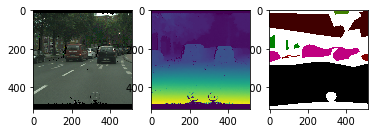

In [74]:
#Same as main method of dataloaders.datasets.coco
city_val = CityscapesSegmentation(cfg, split='val')

dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img_tmp = city_val.loader.invert_normalization(sample['image'].squeeze())
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset='coco')
        plt.figure()
        plt.title('display')
        plt.subplot(131)
        plt.imshow(img_tmp[:,:,:3])
        plt.subplot(133)
        plt.imshow(segmap)
        plt.subplot(132)
        plt.imshow(img_tmp[:,:,3])

    break

plt.show(block=True)

Load a saved model and visualize results
-----

The trained model takes the RGB-D image as input and produces a segmentation mask

In [75]:
import torch
import os
from deeplab3.dataloaders import make_data_loader
from deeplab3.modeling.sync_batchnorm.replicate import patch_replication_callback
from deeplab3.modeling import load_model

In [76]:
from deeplab3.config.defaults import get_cfg_defaults
cfg_rgbd = get_cfg_defaults()
cfg_rgbd.merge_from_file("configs/cityscapes_rgbd.yaml")
cfg_rgbd.merge_from_list(['SYSTEM.GPU_IDS', [0],
                          'TRAIN.RESUME', True, 
                          'RESUME.DIRECTORY', 'run/cityscapes/cityscapes_rgbd_resnet_deeplab/experiment_0/',
                         ])

cfg_rgb = get_cfg_defaults()
cfg_rgb.merge_from_file("configs/cityscapes_rgb.yaml")
cfg_rgb.merge_from_list(['SYSTEM.GPU_IDS', [0],
                         'TRAIN.RESUME', True, 
                         'RESUME.DIRECTORY', 'run/cityscapes/cityscapes_rgb/experiment_1/',
                         ])

rgbd_model = load_model(cfg_rgbd)
rgb_model = load_model(cfg_rgb)

rgbd_model.eval()
rgb_model.eval()

Training backbone from scratch
=> loaded checkpoint 'run/cityscapes/cityscapes_rgbd_resnet_deeplab/experiment_0/checkpoint.pth.tar' (epoch 173)
Training backbone from scratch
=> loaded checkpoint 'run/cityscapes/cityscapes_rgb/experiment_1/checkpoint.pth.tar' (epoch 83)


DataParallel(
  (module): DeepLab(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): SynchronizedBatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [94]:
def run_model(image, target):
    if cfg_rgbd.SYSTEM.CUDA:
        image, target = image.cuda(), target.cuda()
    with torch.no_grad():
        output_rgbd = rgbd_model(image)
        output_rgb = rgb_model(image[:, 0:3, :, :])
    
    pred_rgbd = output_rgbd.data.cpu().numpy()
    pred_rgbd = np.argmax(pred_rgbd, axis=1)
    
    pred_rgb = output_rgb.data.cpu().numpy()
    pred_rgb = np.argmax(pred_rgb, axis=1)
    
    return pred_rgbd, pred_rgb
    #loss = criterion(output, target)
  
def display_results(image, target, pred_rgbd, pred_rgb):
    segmap = decode_segmap(target.numpy(), dataset='cityscapes')
    segmap_rgbd = decode_segmap(pred_rgbd, dataset='cityscapes')
    segmap_rgb = decode_segmap(pred_rgb, dataset='cityscapes')

    plt.figure(figsize=(16, 4))
    plt.subplot(151)
    plt.imshow(image[:,:,:3])
    plt.title('RGB')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(image[:,:,3])
    plt.title('Depth')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(segmap) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
    plt.title('GT')
    plt.axis('off')

    plt.subplot(154)
    plt.imshow(segmap_rgbd) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
    plt.title('RGBD')
    plt.axis('off')

    plt.subplot(155)
    plt.imshow(segmap_rgb) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
    plt.title('RGB')
    plt.axis('off')


['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


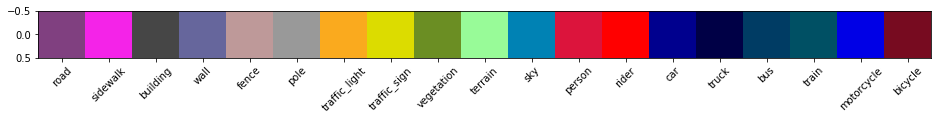

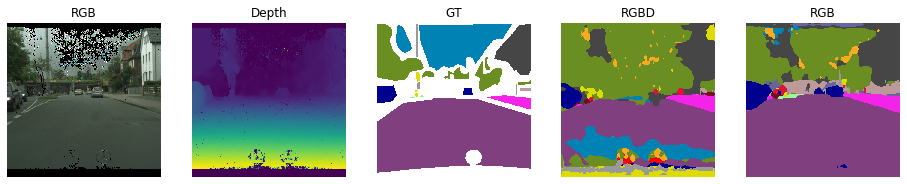

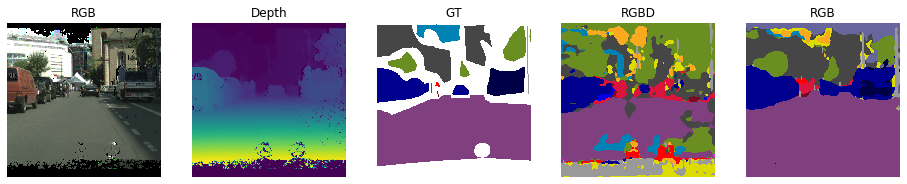

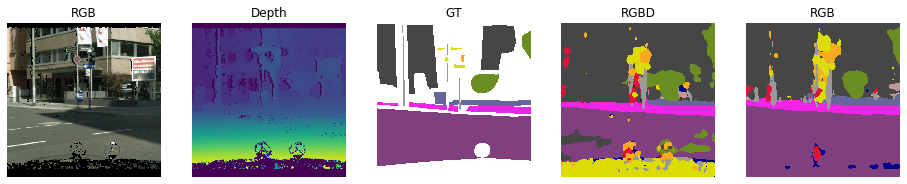

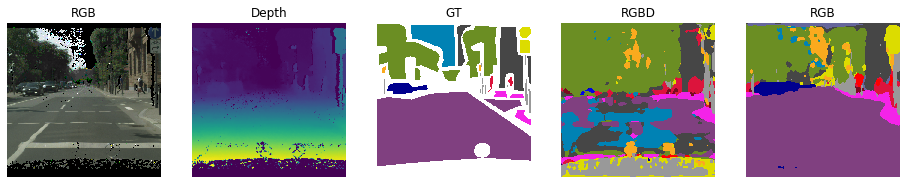

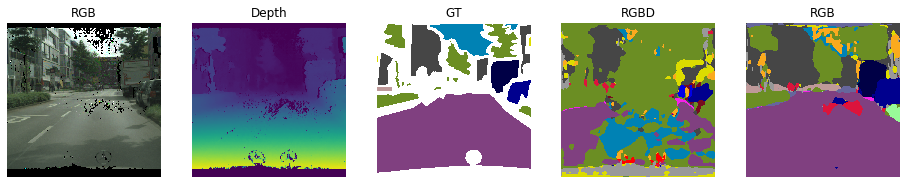

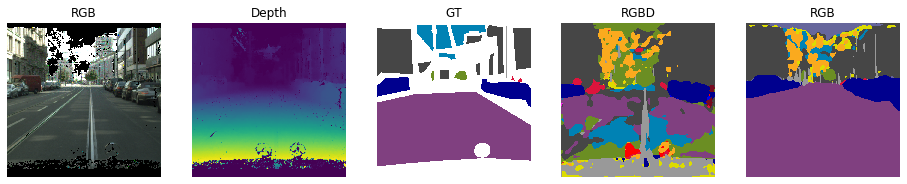

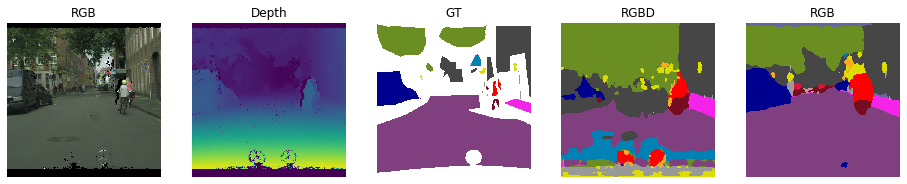

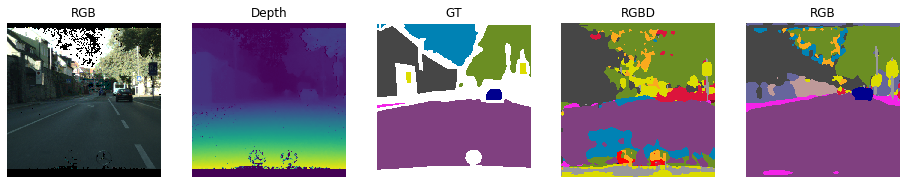

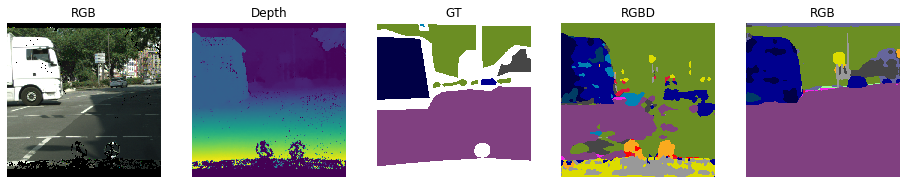

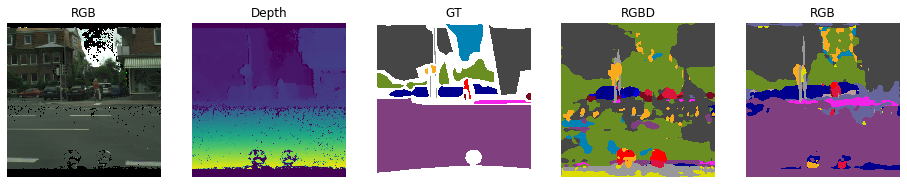

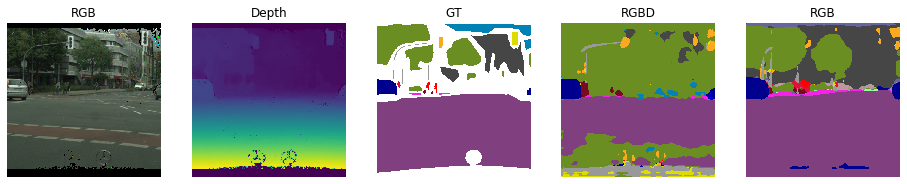

In [98]:
from deeplab3.dataloaders.utils import get_cityscapes_labels

#Class colors for reference
labels = city_val.loader.class_names

plt.figure(figsize=(16, 1))
plt.imshow(np.expand_dims(get_cityscapes_labels(), 0))
plt.xticks(range(len(labels)), labels, rotation=45)
print(labels)

# Test images 

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    pred_rgbd, pred_rgb = run_model(image, target)
    image = city_val.loader.invert_normalization(image.squeeze())
    display_results(image, target.squeeze(), pred_rgbd.squeeze(), pred_rgb.squeeze())
    
    if ii==10:
        break

plt.show(block=True)


Convolutional Filter Visualization
--------

Code modified from https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [8]:
import torch.nn as nn

def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols + 1

def plot_filters_single_channel(t, fig):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 4
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

def plot_filters_multi_channel(t, fig, num_cols=2, current_col=0):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #rows = num of kernels
    num_rows = num_kernels

    #looping through all the kernels
    for i in range(t.shape[0]):
#         if i == 0:
#             print(t[i])
        ind = sub2ind((num_rows, num_cols), i, current_col)
        ax1 = fig.add_subplot(num_rows,num_cols,ind)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        #TODO Is this normalization the correct way of visualizing? 
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        if len(t.shape) == 4:
            npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])   
    
def plot_weights(layer):
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data.cpu()
    
    #set the figure size
    num_cols = 2
    num_rows = weight_tensor.shape[0]
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    plot_filters_multi_channel(weight_tensor[:,:3, :, :], fig)
    plot_filters_multi_channel(weight_tensor[:, 3, :, :], fig, current_col=1)
        
  else:
    print("Can only visualize layers which are convolutional")                          
  
  plt.tight_layout()
  plt.show()

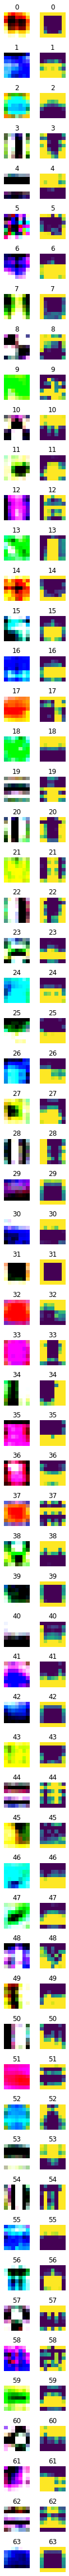

In [9]:
#visualize weights for model - first conv layer
plot_weights(rgbd_model.module.backbone.conv1)


Depth Ablation Study
-----

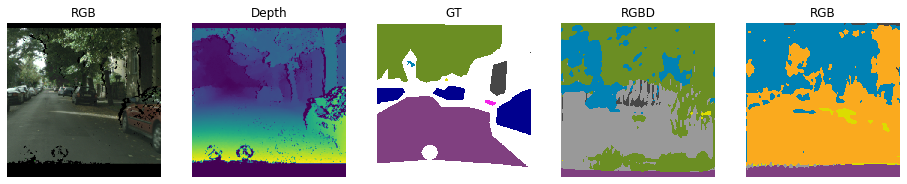

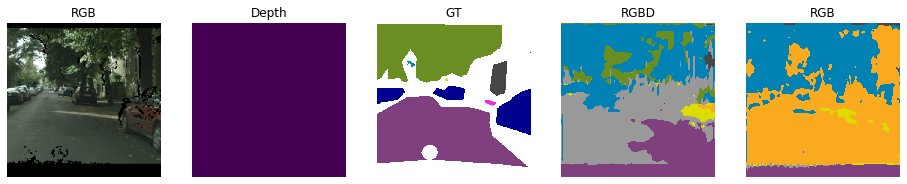

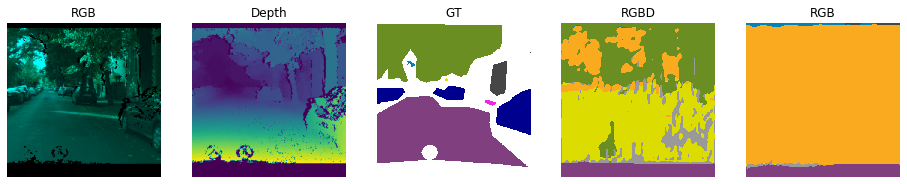

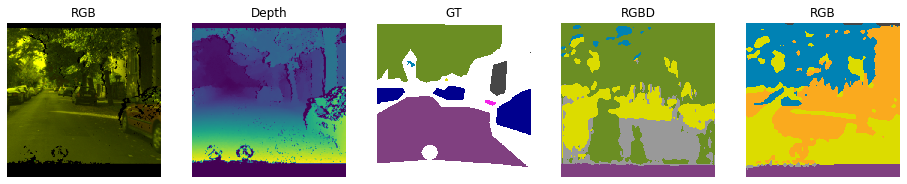

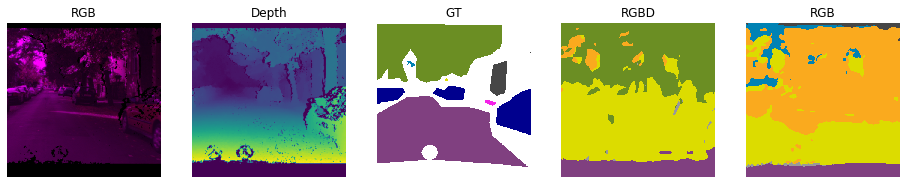

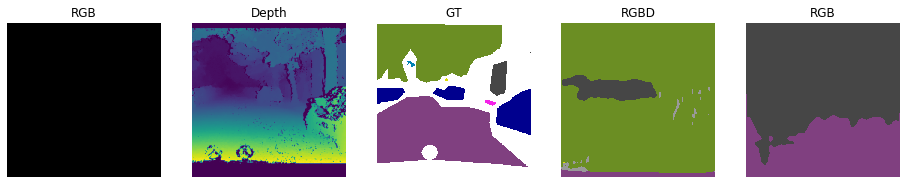

In [10]:
dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    image_vis = city_val.loader.invert_normalization(image.squeeze())
    
    # Full RGBD
    pred_rgbd, pred_rgb = run_model(image, target)
    display_results(image_vis, target, pred_rgbd, pred_rgb)
    
    # No depth
    rgb_image = image.clone()
    rgb_image[:, 3, :, :] = 0
    rgb_image_vis = image_vis.copy()
    rgb_image_vis[:, :, 3] = 0
    pred_rgbd, pred_rgb = run_model(rgb_image, target)
    display_results(rgb_image_vis, target, pred_rgbd, pred_rgb)
    
    # No red channel 
    gbd_image = image.clone()
    gbd_image[:, 0, :, :] = 0
    gbd_image_vis = image_vis.copy()
    gbd_image_vis[:, :, 0] = 0
    pred_rgbd, pred_rgb = run_model(gbd_image, target)
    display_results(gbd_image_vis, target, pred_rgbd, pred_rgb)
    
     # No blue channel 
    rgd_image = image.clone()
    rgd_image[:, 2, :, :] = 0
    rgd_image_vis = image_vis.copy()
    rgd_image_vis[:, :, 2] = 0
    pred_rgbd, pred_rgb = run_model(rgd_image, target)
    display_results(rgd_image_vis, target, pred_rgbd, pred_rgb)
    
     # No green channel 
    rbd_image = image.clone()
    rbd_image[:, 1, :, :] = 0
    rbd_image_vis = image_vis.copy()
    rbd_image_vis[:, :, 1] = 0
    pred_rgbd, pred_rgb = run_model(rbd_image, target)
    display_results(rbd_image_vis, target, pred_rgbd, pred_rgb)
    
    # Depth only
    d_image = image.clone()
    d_image[:, 0:3, :, :] = 0
    d_image_vis = image_vis.copy()
    d_image_vis[:, :, 0:3] = 0
    pred_rgbd, pred_rgb = run_model(d_image, target)
    display_results(d_image_vis, target, pred_rgbd, pred_rgb)

    break

plt.show(block=True)

Loss Comparison
----


Using RGB-D input
Found 19997 train_extra images
Using RGB-D input
Found 500 val images
Using RGB-D input
Found 1525 test images
Training backbone from scratch


:   0%|          | 0/63 [00:00<?, ?it/s]

=> loaded checkpoint 'run/cityscapes/cityscapes_rgbd_resnet_deeplab/experiment_0/checkpoint.pth.tar' (epoch 173)


Test loss: 0.275: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


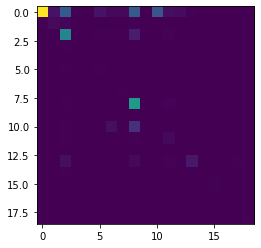

Results:
[numImages:   500]
Acc:0.5772856238790316, Acc_class:0.3837580474848194, mIoU:0.19205314195807557, fwIoU: 0.44193265970292334
Loss: 17.309
Class breakdown:
Class            N_Photos     % Pixels    Accuracy        mIoU
-------------  ----------  -----------  ----------  ----------
road                   63  0.550312      0.488275   0.486109
sidewalk               63  0.0136667     0.504738   0.251204
building               63  0.15516       0.794898   0.482678
wall                   38  0.00355785    0.0993197  0.072534
fence                  46  0.00373501    0.112059   0.0957069
pole                   63  0.00473761    0.354959   0.0835688
traffic_light          49  0.000739827   0.586138   0.0213862
traffic_sign           63  0.00366753    0.564542   0.162592
vegetation             63  0.151123      0.965363   0.488673
terrain                42  0.00119039    0.159406   0.154833
sky                    63  0.0502393     0.0180446  0.00736055
person                 62  0.0091

In [11]:
from deeplab3.test import Tester

test = Tester(cfg_rgbd)
output, mat = test.run(test.val_loader)

Using RGB input
Found 19997 train_extra images
Using RGB input
Found 500 val images
Using RGB input
Found 1525 test images
Training backbone from scratch






:   0%|          | 0/63 [00:00<?, ?it/s]

=> loaded checkpoint 'run/cityscapes/cityscapes_rgb/experiment_1/checkpoint.pth.tar' (epoch 83)






Test loss: 0.002:   0%|          | 0/63 [00:01<?, ?it/s]



Test loss: 0.002:   2%|▏         | 1/63 [00:01<01:40,  1.62s/it]



Test loss: 0.003:   2%|▏         | 1/63 [00:01<01:40,  1.62s/it]



Test loss: 0.003:   3%|▎         | 2/63 [00:02<01:16,  1.25s/it]



Test loss: 0.003:   3%|▎         | 2/63 [00:02<01:16,  1.25s/it]



Test loss: 0.003:   5%|▍         | 3/63 [00:02<01:00,  1.00s/it]



Test loss: 0.004:   5%|▍         | 3/63 [00:02<01:00,  1.00s/it]



Test loss: 0.004:   6%|▋         | 4/63 [00:02<00:48,  1.22it/s]



Test loss: 0.003:   6%|▋         | 4/63 [00:02<00:48,  1.22it/s]



Test loss: 0.003:   8%|▊         | 5/63 [00:03<00:40,  1.43it/s]



Test loss: 0.003:   8%|▊         | 5/63 [00:03<00:40,  1.43it/s]



Test loss: 0.003:  10%|▉         | 6/63 [00:03<00:34,  1.64it/s]



Test loss: 0.004:  10%|▉         | 6/63 [00:03<00:34,  1.64it/s]



Test loss: 0.004:  11%|█         | 7/63 [00:04<00:30,  1.82it/s]



Test loss: 0.004:  11%|█         | 7/63 [00:04<00:30

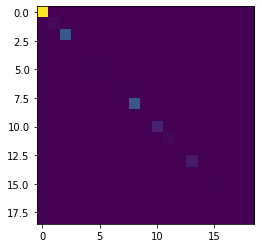

Results:
[numImages:   500]
Acc:0.9793423918965107, Acc_class:0.8121815200273016, mIoU:0.7206803673894441, fwIoU: 0.9628599561945614
Loss: 0.862
Class breakdown:
Class            N_Photos     % Pixels    Accuracy      mIoU
-------------  ----------  -----------  ----------  --------
road                   63  0.550312       0.996323  0.988435
sidewalk               63  0.0136667      0.900344  0.78783
building               63  0.15516        0.96931   0.949855
wall                   38  0.00355785     0.443074  0.339526
fence                  46  0.00373501     0.5261    0.337272
pole                   63  0.00473761     0.773807  0.667072
traffic_light          49  0.000739827    0.84056   0.75918
traffic_sign           63  0.00366753     0.812148  0.768282
vegetation             63  0.151123       0.98663   0.976592
terrain                42  0.00119039     0.945107  0.6347
sky                    63  0.0502393      0.986655  0.975226
person                 62  0.0091607      0.91851

In [43]:
test = Tester(cfg_rgb)
output, mat = test.run(test.val_loader)

In [53]:
from collections import defaultdict
from tqdm import tqdm

class ImageEvaluator(object):
    def __init__(self):
        self.images_by_accuracy = defaultdict(list)
        self.images_by_iou = defaultdict(list)
        self.image_stats = defaultdict(dict)

    def add_image(self, gt_image, pre_image, img_id):
        accuracy = (np.equal(gt_image, pre_image).sum()/float(gt_image.numel())).item()
        intersection = np.logical_and(gt_image, pre_image).sum()
        union = np.logical_and(gt_image, pre_image).sum()+np.logical_xor(gt_image, pre_image).sum()
        iou = float(intersection)/float(union)

        self.images_by_iou[iou].append(img_id)
        self.images_by_accuracy[accuracy].append(img_id)
        self.image_stats[img_id] = {'iou': iou,
                                       'accuracy': accuracy}

    def top_n(self, n=10):
        return {'accuracy': {key: self.images_by_accuracy[key] for key in sorted(self.images_by_accuracy)[:n]},
                'iou': {key: self.images_by_iou[key] for key in sorted(self.images_by_iou)[:n]}}

    def bottom_n(self, n=10):
        return {'accuracy': {key: self.images_by_accuracy[key] for key in sorted(self.images_by_accuracy, reverse=True)[:n]},
                'iou': {key: self.images_by_iou[key] for key in sorted(self.images_by_iou, reverse=True)[:n]}}

img_evaluator_rgbd = ImageEvaluator()
img_evaluator_rgb = ImageEvaluator()

tbar = tqdm(city_val, desc='\r')
for i, sample in enumerate(tbar):
    image, target = sample['image'], sample['label']
    output_rgbd, output_rgb = run_model(image.unsqueeze(0), target.unsqueeze(0))

    img_evaluator_rgbd.add_image(target, output_rgbd, i)
    img_evaluator_rgb.add_image(target, output_rgb, i)





:   0%|          | 0/500 [00:00<?, ?it/s]



:   0%|          | 1/500 [00:00<02:32,  3.26it/s]



:   0%|          | 2/500 [00:00<02:29,  3.32it/s]



:   1%|          | 3/500 [00:00<02:27,  3.38it/s]



:   1%|          | 4/500 [00:01<02:24,  3.43it/s]



:   1%|          | 5/500 [00:01<02:22,  3.48it/s]



:   1%|          | 6/500 [00:01<02:20,  3.51it/s]



:   1%|▏         | 7/500 [00:01<02:19,  3.53it/s]



:   2%|▏         | 8/500 [00:02<02:18,  3.54it/s]



:   2%|▏         | 9/500 [00:02<02:18,  3.55it/s]



:   2%|▏         | 10/500 [00:02<02:18,  3.54it/s]



:   2%|▏         | 11/500 [00:03<02:17,  3.55it/s]



:   2%|▏         | 12/500 [00:03<02:17,  3.55it/s]



:   3%|▎         | 13/500 [00:03<02:17,  3.55it/s]



:   3%|▎         | 14/500 [00:03<02:16,  3.55it/s]



:   3%|▎         | 15/500 [00:04<02:16,  3.56it/s]



:   3%|▎         | 16/500 [00:04<02:16,  3.56it/s]



:   3%|▎         | 17/500 [00:04<02:16,  3.54it/s]



:   4%|▎         | 18/500 [00:05<02:16,  3

:  25%|██▍       | 124/500 [00:34<01:44,  3.59it/s]



:  25%|██▌       | 125/500 [00:35<01:44,  3.60it/s]



:  25%|██▌       | 126/500 [00:35<01:43,  3.60it/s]



:  25%|██▌       | 127/500 [00:35<01:43,  3.61it/s]



:  26%|██▌       | 128/500 [00:35<01:43,  3.61it/s]



:  26%|██▌       | 129/500 [00:36<01:43,  3.60it/s]



:  26%|██▌       | 130/500 [00:36<01:43,  3.59it/s]



:  26%|██▌       | 131/500 [00:36<01:42,  3.60it/s]



:  26%|██▋       | 132/500 [00:36<01:42,  3.60it/s]



:  27%|██▋       | 133/500 [00:37<01:41,  3.60it/s]



:  27%|██▋       | 134/500 [00:37<01:41,  3.60it/s]



:  27%|██▋       | 135/500 [00:37<01:41,  3.59it/s]



:  27%|██▋       | 136/500 [00:38<01:41,  3.58it/s]



:  27%|██▋       | 137/500 [00:38<01:43,  3.49it/s]



:  28%|██▊       | 138/500 [00:38<01:42,  3.52it/s]



:  28%|██▊       | 139/500 [00:38<01:42,  3.54it/s]



:  28%|██▊       | 140/500 [00:39<01:41,  3.55it/s]



:  28%|██▊       | 141/500 [00:39<01:40,  3.58it/s]



:  28%|██▊

:  74%|███████▎  | 368/500 [01:43<00:37,  3.56it/s]



:  74%|███████▍  | 369/500 [01:44<00:36,  3.56it/s]



:  74%|███████▍  | 370/500 [01:44<00:36,  3.57it/s]



:  74%|███████▍  | 371/500 [01:44<00:36,  3.57it/s]



:  74%|███████▍  | 372/500 [01:45<00:35,  3.57it/s]



:  75%|███████▍  | 373/500 [01:45<00:35,  3.56it/s]



:  75%|███████▍  | 374/500 [01:45<00:35,  3.56it/s]



:  75%|███████▌  | 375/500 [01:45<00:35,  3.55it/s]



:  75%|███████▌  | 376/500 [01:46<00:34,  3.55it/s]



:  75%|███████▌  | 377/500 [01:46<00:34,  3.56it/s]



:  76%|███████▌  | 378/500 [01:46<00:34,  3.58it/s]



:  76%|███████▌  | 379/500 [01:47<00:33,  3.57it/s]



:  76%|███████▌  | 380/500 [01:47<00:33,  3.56it/s]



:  76%|███████▌  | 381/500 [01:47<00:33,  3.56it/s]



:  76%|███████▋  | 382/500 [01:47<00:33,  3.55it/s]



:  77%|███████▋  | 383/500 [01:48<00:32,  3.55it/s]



:  77%|███████▋  | 384/500 [01:48<00:32,  3.55it/s]



:  77%|███████▋  | 385/500 [01:48<00:32,  3.49it/s]



:  77%|███

In [55]:
img_evaluator_rgb.bottom_n(n=5)

{'accuracy': {tensor(0.8189): [195],
  tensor(0.8124): [226],
  tensor(0.7809): [202],
  tensor(0.7619): [180],
  tensor(0.7494): [102]},
 'iou': {0.9329395793875831: [209],
  0.9259561733334795: [192],
  0.9230171639435799: [219],
  0.9228988253327869: [228],
  0.9187636162438186: [202]}}

{'iou': 0.46980457424696676, 'accuracy': tensor(0.1621)}
{'iou': 0.47156390000341986, 'accuracy': tensor(0.2035)}
{'iou': 0.41795342645524625, 'accuracy': tensor(0.2075)}
{'iou': 0.6012427023723005, 'accuracy': tensor(0.2412)}
{'iou': 0.612165566613089, 'accuracy': tensor(0.2712)}


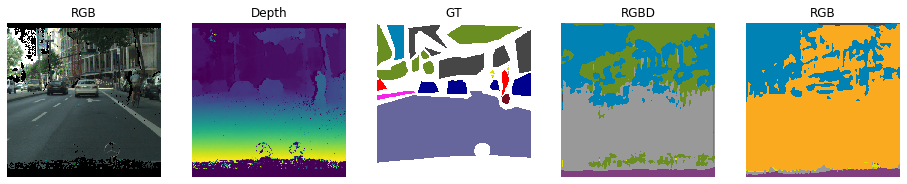

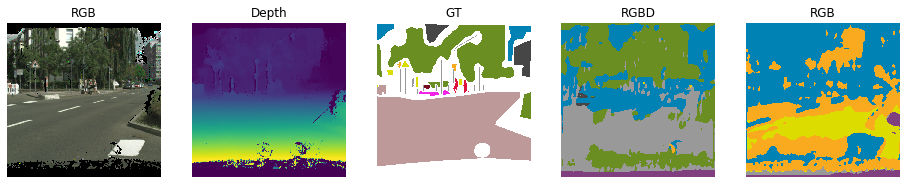

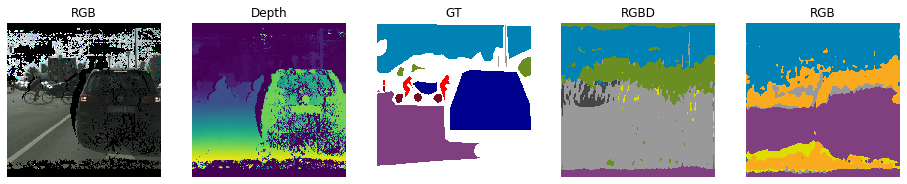

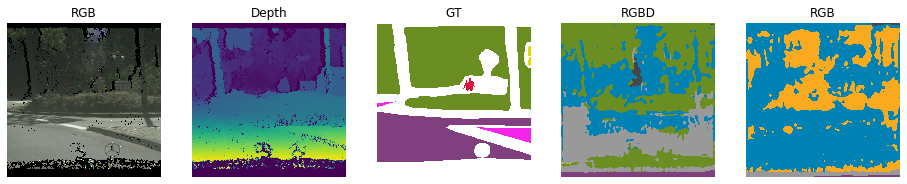

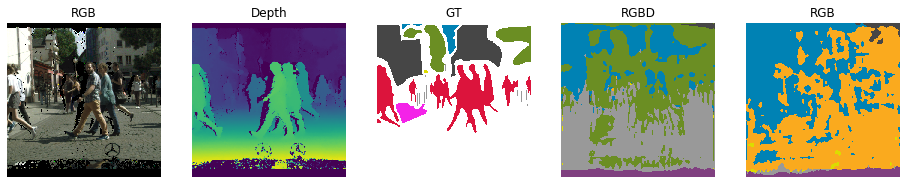

In [102]:
for ii in [x for key,value in img_evaluator_rgb.top_n(n=5)['accuracy'].items() for x in value]:
    sample = city_val[ii]
    image, target = sample['image'], sample['label']
    image_vis = city_val.loader.invert_normalization(image.squeeze())
    
    # Full RGBD
    pred_rgbd, pred_rgb = run_model(image.unsqueeze(0), target)
    print(img_evaluator_rgb.image_stats[ii])
    display_results(image_vis, target.squeeze(), pred_rgbd.squeeze(), pred_rgb.squeeze())

In [100]:
[value for key,value in img_evaluator_rgb.bottom_n(n=5)['accuracy'].items()]

[[195], [226], [202], [180], [102]]